In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SEED = 1987
data_dir = ''
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [3]:
# This part is optional for if you want to train only on most popular classes. 
# NUM_CLASSES = 16
# selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
# labels = labels[labels['breed'].isin(selected_breed_list)]

In [4]:
labels['target'] = 1
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot.values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [5]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [6]:
INPUT_SIZE = 224
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:37, 273.74it/s]


Train Images shape: (10222, 224, 224, 3) size: 1,538,697,216


In [7]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

((8140, 224, 224, 3), (2082, 224, 224, 3), (8140, 121), (2082, 121))


In [8]:
del x_train

In [9]:
model_resnet50 = ResNet50(weights='imagenet',include_top=False, input_shape = (INPUT_SIZE,INPUT_SIZE,3))
x = model_resnet50.get_layer(model_resnet50.layers[-2].name).output
x = Flatten(name="Last_flatterning")(x)
x = Dense(256, activation='relu', name='Last_Relu')(x)
predictions = Dense(ytr.shape[1]-1, activation='softmax',name='Last_softmax')(x) 
model = Model(inputs=model_resnet50.input, outputs=predictions)

In [10]:
for i, layer in enumerate(model.layers[:-3]):
   layer.trainable = False
   #print(i, layer.name,layer.trainable)   

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ["accuracy"])

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model.fit(x = Xtr, y = ytr[:,1:], epochs = 10, batch_size = 256,validation_data = [Xv,yv[:,1:]],callbacks=[reduce_lr])

Train on 8140 samples, validate on 2082 samples
Epoch 1/10
8140/8140 [==============================] - ETA: 2:40 - loss: 6.5552 - acc: 0.003 - ETA: 1:36 - loss: 9.0649 - acc: 0.015 - ETA: 1:15 - loss: 10.4972 - acc: 0.01 - ETA: 1:03 - loss: 11.2541 - acc: 0.01 - ETA: 55s - loss: 11.5747 - acc: 0.0219 - ETA: 50s - loss: 11.5945 - acc: 0.028 - ETA: 46s - loss: 11.5941 - acc: 0.044 - ETA: 42s - loss: 11.6862 - acc: 0.047 - ETA: 39s - loss: 11.5597 - acc: 0.059 - ETA: 37s - loss: 11.5678 - acc: 0.065 - ETA: 34s - loss: 11.4687 - acc: 0.076 - ETA: 32s - loss: 11.3534 - acc: 0.083 - ETA: 30s - loss: 11.2550 - acc: 0.091 - ETA: 28s - loss: 11.0993 - acc: 0.097 - ETA: 26s - loss: 10.9760 - acc: 0.101 - ETA: 24s - loss: 10.8782 - acc: 0.106 - ETA: 22s - loss: 10.7798 - acc: 0.113 - ETA: 21s - loss: 10.7272 - acc: 0.117 - ETA: 19s - loss: 10.6434 - acc: 0.120 - ETA: 17s - loss: 10.5374 - acc: 0.127 - ETA: 16s - loss: 10.4410 - acc: 0.133 - ETA: 14s - loss: 10.3981 - acc: 0.134 - ETA: 13s - loss

8140/8140 [==============================] - ETA: 40s - loss: 0.0355 - acc: 0.99 - ETA: 39s - loss: 0.0629 - acc: 0.98 - ETA: 38s - loss: 0.0551 - acc: 0.98 - ETA: 36s - loss: 0.0653 - acc: 0.98 - ETA: 35s - loss: 0.0569 - acc: 0.98 - ETA: 34s - loss: 0.0574 - acc: 0.98 - ETA: 33s - loss: 0.0543 - acc: 0.98 - ETA: 31s - loss: 0.0542 - acc: 0.98 - ETA: 30s - loss: 0.0521 - acc: 0.98 - ETA: 29s - loss: 0.0518 - acc: 0.98 - ETA: 27s - loss: 0.0569 - acc: 0.98 - ETA: 26s - loss: 0.0572 - acc: 0.98 - ETA: 25s - loss: 0.0584 - acc: 0.98 - ETA: 23s - loss: 0.0590 - acc: 0.98 - ETA: 22s - loss: 0.0586 - acc: 0.98 - ETA: 21s - loss: 0.0622 - acc: 0.98 - ETA: 19s - loss: 0.0618 - acc: 0.98 - ETA: 18s - loss: 0.0620 - acc: 0.98 - ETA: 17s - loss: 0.0615 - acc: 0.98 - ETA: 15s - loss: 0.0623 - acc: 0.98 - ETA: 14s - loss: 0.0618 - acc: 0.98 - ETA: 13s - loss: 0.0648 - acc: 0.98 - ETA: 11s - loss: 0.0643 - acc: 0.98 - ETA: 10s - loss: 0.0664 - acc: 0.98 - ETA: 9s - loss: 0.0660 - acc: 0.9864 - ETA:

In [13]:
model.save_weights('trained_weights_resenet50_stage1.h5')

In [14]:
#model.load_weights('trained_weights_resenet50_stage1.h5')

In [15]:
for i, layer in enumerate(model.layers):
   layer.trainable = True

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy',metrics = ["accuracy"])
model.fit(x = Xtr, y = ytr[:,1:], epochs = 20, batch_size = 8,validation_data = [Xv,yv[:,1:]],callbacks=[reduce_lr, early_stopping])

Train on 8140 samples, validate on 2082 samples
Epoch 1/20


1624/8140 [====>.........................] - ETA: 2:31:24 - loss: 0.2630 - acc: 0.87 - ETA: 1:17:41 - loss: 0.1432 - acc: 0.93 - ETA: 53:09 - loss: 0.1217 - acc: 0.9583 - ETA: 40:52 - loss: 0.0944 - acc: 0.96 - ETA: 33:29 - loss: 0.0836 - acc: 0.97 - ETA: 28:35 - loss: 0.1233 - acc: 0.93 - ETA: 25:04 - loss: 0.1557 - acc: 0.92 - ETA: 22:25 - loss: 0.3973 - acc: 0.90 - ETA: 20:22 - loss: 0.3745 - acc: 0.91 - ETA: 18:43 - loss: 0.4364 - acc: 0.90 - ETA: 17:22 - loss: 0.4681 - acc: 0.88 - ETA: 16:15 - loss: 0.4298 - acc: 0.89 - ETA: 15:18 - loss: 0.4035 - acc: 0.90 - ETA: 14:29 - loss: 0.3772 - acc: 0.91 - ETA: 13:46 - loss: 0.3679 - acc: 0.90 - ETA: 13:09 - loss: 0.3465 - acc: 0.91 - ETA: 12:37 - loss: 0.3290 - acc: 0.91 - ETA: 12:08 - loss: 0.3144 - acc: 0.92 - ETA: 11:42 - loss: 0.3076 - acc: 0.92 - ETA: 11:19 - loss: 0.3142 - acc: 0.91 - ETA: 10:58 - loss: 0.3009 - acc: 0.92 - ETA: 10:39 - loss: 0.2891 - acc: 0.92 - ETA: 10:21 - loss: 0.2898 - acc: 0.92 - ETA: 10:05 - loss: 0.2856 - a

3256/8140 [===========>..................] - ETA: 3:57 - loss: 0.2050 - acc: 0.938 - ETA: 3:57 - loss: 0.2076 - acc: 0.937 - ETA: 3:57 - loss: 0.2068 - acc: 0.938 - ETA: 3:56 - loss: 0.2058 - acc: 0.938 - ETA: 3:56 - loss: 0.2049 - acc: 0.938 - ETA: 3:55 - loss: 0.2048 - acc: 0.939 - ETA: 3:55 - loss: 0.2040 - acc: 0.939 - ETA: 3:54 - loss: 0.2066 - acc: 0.938 - ETA: 3:54 - loss: 0.2081 - acc: 0.937 - ETA: 3:53 - loss: 0.2099 - acc: 0.937 - ETA: 3:53 - loss: 0.2090 - acc: 0.937 - ETA: 3:53 - loss: 0.2083 - acc: 0.937 - ETA: 3:52 - loss: 0.2075 - acc: 0.938 - ETA: 3:52 - loss: 0.2067 - acc: 0.938 - ETA: 3:51 - loss: 0.2060 - acc: 0.938 - ETA: 3:51 - loss: 0.2065 - acc: 0.938 - ETA: 3:50 - loss: 0.2057 - acc: 0.938 - ETA: 3:50 - loss: 0.2050 - acc: 0.938 - ETA: 3:50 - loss: 0.2041 - acc: 0.939 - ETA: 3:49 - loss: 0.2032 - acc: 0.939 - ETA: 3:49 - loss: 0.2025 - acc: 0.939 - ETA: 3:48 - loss: 0.2017 - acc: 0.940 - ETA: 3:48 - loss: 0.2019 - acc: 0.939 - ETA: 3:48 - loss: 0.2011 - acc: 0.9

4888/8140 [=================>............] - ETA: 2:45 - loss: 0.1883 - acc: 0.941 - ETA: 2:45 - loss: 0.1886 - acc: 0.941 - ETA: 2:45 - loss: 0.1887 - acc: 0.941 - ETA: 2:44 - loss: 0.1890 - acc: 0.941 - ETA: 2:44 - loss: 0.1886 - acc: 0.941 - ETA: 2:44 - loss: 0.1881 - acc: 0.941 - ETA: 2:43 - loss: 0.1882 - acc: 0.941 - ETA: 2:43 - loss: 0.1880 - acc: 0.941 - ETA: 2:43 - loss: 0.1878 - acc: 0.941 - ETA: 2:42 - loss: 0.1875 - acc: 0.941 - ETA: 2:42 - loss: 0.1871 - acc: 0.942 - ETA: 2:42 - loss: 0.1868 - acc: 0.942 - ETA: 2:42 - loss: 0.1865 - acc: 0.942 - ETA: 2:41 - loss: 0.1861 - acc: 0.942 - ETA: 2:41 - loss: 0.1857 - acc: 0.942 - ETA: 2:41 - loss: 0.1854 - acc: 0.942 - ETA: 2:40 - loss: 0.1854 - acc: 0.942 - ETA: 2:40 - loss: 0.1850 - acc: 0.942 - ETA: 2:40 - loss: 0.1846 - acc: 0.942 - ETA: 2:39 - loss: 0.1846 - acc: 0.942 - ETA: 2:39 - loss: 0.1842 - acc: 0.942 - ETA: 2:39 - loss: 0.1839 - acc: 0.942 - ETA: 2:39 - loss: 0.1836 - acc: 0.943 - ETA: 2:38 - loss: 0.1835 - acc: 0.9

6536/8140 [=======================>......] - ETA: 1:47 - loss: 0.1804 - acc: 0.946 - ETA: 1:47 - loss: 0.1801 - acc: 0.947 - ETA: 1:46 - loss: 0.1801 - acc: 0.947 - ETA: 1:46 - loss: 0.1798 - acc: 0.947 - ETA: 1:46 - loss: 0.1800 - acc: 0.946 - ETA: 1:46 - loss: 0.1798 - acc: 0.946 - ETA: 1:45 - loss: 0.1796 - acc: 0.947 - ETA: 1:45 - loss: 0.1795 - acc: 0.947 - ETA: 1:45 - loss: 0.1793 - acc: 0.947 - ETA: 1:44 - loss: 0.1793 - acc: 0.947 - ETA: 1:44 - loss: 0.1794 - acc: 0.947 - ETA: 1:44 - loss: 0.1792 - acc: 0.947 - ETA: 1:44 - loss: 0.1789 - acc: 0.947 - ETA: 1:43 - loss: 0.1789 - acc: 0.947 - ETA: 1:43 - loss: 0.1786 - acc: 0.947 - ETA: 1:43 - loss: 0.1799 - acc: 0.947 - ETA: 1:43 - loss: 0.1797 - acc: 0.947 - ETA: 1:42 - loss: 0.1794 - acc: 0.947 - ETA: 1:42 - loss: 0.1795 - acc: 0.947 - ETA: 1:42 - loss: 0.1792 - acc: 0.947 - ETA: 1:41 - loss: 0.1790 - acc: 0.947 - ETA: 1:41 - loss: 0.1787 - acc: 0.947 - ETA: 1:41 - loss: 0.1786 - acc: 0.947 - ETA: 1:41 - loss: 0.1786 - acc: 0.9

8140/8140 [==============================] - ETA: 52s - loss: 0.1841 - acc: 0.94 - ETA: 51s - loss: 0.1840 - acc: 0.94 - ETA: 51s - loss: 0.1840 - acc: 0.94 - ETA: 51s - loss: 0.1841 - acc: 0.94 - ETA: 51s - loss: 0.1839 - acc: 0.94 - ETA: 50s - loss: 0.1840 - acc: 0.94 - ETA: 50s - loss: 0.1843 - acc: 0.94 - ETA: 50s - loss: 0.1848 - acc: 0.94 - ETA: 50s - loss: 0.1847 - acc: 0.94 - ETA: 49s - loss: 0.1846 - acc: 0.94 - ETA: 49s - loss: 0.1844 - acc: 0.94 - ETA: 49s - loss: 0.1842 - acc: 0.94 - ETA: 48s - loss: 0.1841 - acc: 0.94 - ETA: 48s - loss: 0.1839 - acc: 0.94 - ETA: 48s - loss: 0.1838 - acc: 0.94 - ETA: 48s - loss: 0.1836 - acc: 0.94 - ETA: 47s - loss: 0.1835 - acc: 0.94 - ETA: 47s - loss: 0.1833 - acc: 0.94 - ETA: 47s - loss: 0.1831 - acc: 0.94 - ETA: 47s - loss: 0.1829 - acc: 0.94 - ETA: 46s - loss: 0.1831 - acc: 0.94 - ETA: 46s - loss: 0.1829 - acc: 0.94 - ETA: 46s - loss: 0.1828 - acc: 0.94 - ETA: 46s - loss: 0.1829 - acc: 0.94 - ETA: 45s - loss: 0.1827 - acc: 0.94 - ETA: 

1632/8140 [=====>........................] - ETA: 4:10 - loss: 0.0352 - acc: 1.000 - ETA: 4:10 - loss: 0.0373 - acc: 1.000 - ETA: 4:12 - loss: 0.0875 - acc: 0.958 - ETA: 4:12 - loss: 0.0776 - acc: 0.968 - ETA: 4:13 - loss: 0.1847 - acc: 0.950 - ETA: 4:12 - loss: 0.1739 - acc: 0.958 - ETA: 4:12 - loss: 0.1495 - acc: 0.964 - ETA: 4:12 - loss: 0.1413 - acc: 0.968 - ETA: 4:12 - loss: 0.1285 - acc: 0.972 - ETA: 4:12 - loss: 0.1204 - acc: 0.975 - ETA: 4:12 - loss: 0.1115 - acc: 0.977 - ETA: 4:12 - loss: 0.1077 - acc: 0.979 - ETA: 4:12 - loss: 0.1175 - acc: 0.971 - ETA: 4:11 - loss: 0.1248 - acc: 0.973 - ETA: 4:11 - loss: 0.1224 - acc: 0.975 - ETA: 4:11 - loss: 0.1158 - acc: 0.976 - ETA: 4:10 - loss: 0.1150 - acc: 0.977 - ETA: 4:10 - loss: 0.1137 - acc: 0.979 - ETA: 4:10 - loss: 0.1099 - acc: 0.980 - ETA: 4:09 - loss: 0.1051 - acc: 0.981 - ETA: 4:09 - loss: 0.1019 - acc: 0.982 - ETA: 4:09 - loss: 0.1023 - acc: 0.983 - ETA: 4:09 - loss: 0.0983 - acc: 0.983 - ETA: 4:08 - loss: 0.0962 - acc: 0.9

3264/8140 [===========>..................] - ETA: 3:23 - loss: 0.1131 - acc: 0.968 - ETA: 3:23 - loss: 0.1126 - acc: 0.969 - ETA: 3:23 - loss: 0.1121 - acc: 0.969 - ETA: 3:23 - loss: 0.1116 - acc: 0.969 - ETA: 3:22 - loss: 0.1111 - acc: 0.969 - ETA: 3:22 - loss: 0.1118 - acc: 0.969 - ETA: 3:22 - loss: 0.1113 - acc: 0.969 - ETA: 3:22 - loss: 0.1114 - acc: 0.969 - ETA: 3:21 - loss: 0.1109 - acc: 0.969 - ETA: 3:21 - loss: 0.1104 - acc: 0.969 - ETA: 3:21 - loss: 0.1099 - acc: 0.969 - ETA: 3:21 - loss: 0.1095 - acc: 0.969 - ETA: 3:20 - loss: 0.1092 - acc: 0.970 - ETA: 3:20 - loss: 0.1104 - acc: 0.969 - ETA: 3:20 - loss: 0.1101 - acc: 0.969 - ETA: 3:20 - loss: 0.1096 - acc: 0.969 - ETA: 3:19 - loss: 0.1095 - acc: 0.970 - ETA: 3:19 - loss: 0.1090 - acc: 0.970 - ETA: 3:19 - loss: 0.1085 - acc: 0.970 - ETA: 3:19 - loss: 0.1081 - acc: 0.970 - ETA: 3:18 - loss: 0.1095 - acc: 0.970 - ETA: 3:18 - loss: 0.1090 - acc: 0.970 - ETA: 3:18 - loss: 0.1088 - acc: 0.970 - ETA: 3:18 - loss: 0.1113 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:32 - loss: 0.1100 - acc: 0.969 - ETA: 2:32 - loss: 0.1100 - acc: 0.969 - ETA: 2:31 - loss: 0.1097 - acc: 0.969 - ETA: 2:31 - loss: 0.1099 - acc: 0.969 - ETA: 2:31 - loss: 0.1097 - acc: 0.969 - ETA: 2:31 - loss: 0.1097 - acc: 0.969 - ETA: 2:30 - loss: 0.1096 - acc: 0.969 - ETA: 2:30 - loss: 0.1105 - acc: 0.969 - ETA: 2:30 - loss: 0.1104 - acc: 0.969 - ETA: 2:30 - loss: 0.1102 - acc: 0.969 - ETA: 2:29 - loss: 0.1099 - acc: 0.969 - ETA: 2:29 - loss: 0.1100 - acc: 0.969 - ETA: 2:29 - loss: 0.1099 - acc: 0.969 - ETA: 2:29 - loss: 0.1097 - acc: 0.969 - ETA: 2:28 - loss: 0.1103 - acc: 0.969 - ETA: 2:28 - loss: 0.1102 - acc: 0.969 - ETA: 2:28 - loss: 0.1100 - acc: 0.969 - ETA: 2:28 - loss: 0.1099 - acc: 0.969 - ETA: 2:27 - loss: 0.1096 - acc: 0.969 - ETA: 2:27 - loss: 0.1094 - acc: 0.969 - ETA: 2:27 - loss: 0.1092 - acc: 0.969 - ETA: 2:27 - loss: 0.1090 - acc: 0.969 - ETA: 2:26 - loss: 0.1089 - acc: 0.969 - ETA: 2:26 - loss: 0.1091 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:41 - loss: 0.1058 - acc: 0.971 - ETA: 1:41 - loss: 0.1056 - acc: 0.971 - ETA: 1:40 - loss: 0.1055 - acc: 0.972 - ETA: 1:40 - loss: 0.1053 - acc: 0.972 - ETA: 1:40 - loss: 0.1052 - acc: 0.972 - ETA: 1:40 - loss: 0.1051 - acc: 0.972 - ETA: 1:39 - loss: 0.1050 - acc: 0.972 - ETA: 1:39 - loss: 0.1050 - acc: 0.972 - ETA: 1:39 - loss: 0.1049 - acc: 0.972 - ETA: 1:39 - loss: 0.1048 - acc: 0.972 - ETA: 1:38 - loss: 0.1047 - acc: 0.972 - ETA: 1:38 - loss: 0.1046 - acc: 0.972 - ETA: 1:38 - loss: 0.1045 - acc: 0.972 - ETA: 1:38 - loss: 0.1045 - acc: 0.972 - ETA: 1:37 - loss: 0.1046 - acc: 0.972 - ETA: 1:37 - loss: 0.1050 - acc: 0.972 - ETA: 1:37 - loss: 0.1049 - acc: 0.972 - ETA: 1:37 - loss: 0.1050 - acc: 0.972 - ETA: 1:36 - loss: 0.1048 - acc: 0.972 - ETA: 1:36 - loss: 0.1049 - acc: 0.972 - ETA: 1:36 - loss: 0.1049 - acc: 0.972 - ETA: 1:36 - loss: 0.1047 - acc: 0.972 - ETA: 1:35 - loss: 0.1046 - acc: 0.972 - ETA: 1:35 - loss: 0.1047 - acc: 0.9

8140/8140 [==============================] - ETA: 49s - loss: 0.1036 - acc: 0.97 - ETA: 49s - loss: 0.1035 - acc: 0.97 - ETA: 49s - loss: 0.1035 - acc: 0.97 - ETA: 48s - loss: 0.1034 - acc: 0.97 - ETA: 48s - loss: 0.1034 - acc: 0.97 - ETA: 48s - loss: 0.1035 - acc: 0.97 - ETA: 48s - loss: 0.1035 - acc: 0.97 - ETA: 47s - loss: 0.1036 - acc: 0.97 - ETA: 47s - loss: 0.1034 - acc: 0.97 - ETA: 47s - loss: 0.1033 - acc: 0.97 - ETA: 47s - loss: 0.1033 - acc: 0.97 - ETA: 46s - loss: 0.1033 - acc: 0.97 - ETA: 46s - loss: 0.1034 - acc: 0.97 - ETA: 46s - loss: 0.1032 - acc: 0.97 - ETA: 46s - loss: 0.1032 - acc: 0.97 - ETA: 45s - loss: 0.1031 - acc: 0.97 - ETA: 45s - loss: 0.1031 - acc: 0.97 - ETA: 45s - loss: 0.1038 - acc: 0.97 - ETA: 45s - loss: 0.1038 - acc: 0.97 - ETA: 44s - loss: 0.1037 - acc: 0.97 - ETA: 44s - loss: 0.1036 - acc: 0.97 - ETA: 44s - loss: 0.1035 - acc: 0.97 - ETA: 44s - loss: 0.1035 - acc: 0.97 - ETA: 43s - loss: 0.1034 - acc: 0.97 - ETA: 43s - loss: 0.1033 - acc: 0.97 - ETA: 

1632/8140 [=====>........................] - ETA: 4:08 - loss: 0.0164 - acc: 1.000 - ETA: 4:10 - loss: 0.0261 - acc: 1.000 - ETA: 4:11 - loss: 0.0524 - acc: 1.000 - ETA: 4:11 - loss: 0.0418 - acc: 1.000 - ETA: 4:11 - loss: 0.0808 - acc: 0.975 - ETA: 4:11 - loss: 0.0690 - acc: 0.979 - ETA: 4:11 - loss: 0.0732 - acc: 0.982 - ETA: 4:12 - loss: 0.0664 - acc: 0.984 - ETA: 4:12 - loss: 0.0653 - acc: 0.986 - ETA: 4:11 - loss: 0.0658 - acc: 0.987 - ETA: 4:11 - loss: 0.0602 - acc: 0.988 - ETA: 4:10 - loss: 0.0721 - acc: 0.979 - ETA: 4:10 - loss: 0.0754 - acc: 0.980 - ETA: 4:10 - loss: 0.0717 - acc: 0.982 - ETA: 4:09 - loss: 0.0707 - acc: 0.983 - ETA: 4:09 - loss: 0.0663 - acc: 0.984 - ETA: 4:09 - loss: 0.0764 - acc: 0.985 - ETA: 4:09 - loss: 0.0738 - acc: 0.986 - ETA: 4:09 - loss: 0.0707 - acc: 0.986 - ETA: 4:09 - loss: 0.0679 - acc: 0.987 - ETA: 4:09 - loss: 0.0661 - acc: 0.988 - ETA: 4:08 - loss: 0.0641 - acc: 0.988 - ETA: 4:08 - loss: 0.0614 - acc: 0.989 - ETA: 4:08 - loss: 0.0599 - acc: 0.9

3264/8140 [===========>..................] - ETA: 3:23 - loss: 0.0777 - acc: 0.982 - ETA: 3:23 - loss: 0.0779 - acc: 0.983 - ETA: 3:22 - loss: 0.0788 - acc: 0.982 - ETA: 3:22 - loss: 0.0786 - acc: 0.982 - ETA: 3:22 - loss: 0.0783 - acc: 0.982 - ETA: 3:22 - loss: 0.0780 - acc: 0.982 - ETA: 3:21 - loss: 0.0785 - acc: 0.982 - ETA: 3:21 - loss: 0.0782 - acc: 0.982 - ETA: 3:21 - loss: 0.0779 - acc: 0.982 - ETA: 3:21 - loss: 0.0779 - acc: 0.982 - ETA: 3:20 - loss: 0.0776 - acc: 0.982 - ETA: 3:20 - loss: 0.0779 - acc: 0.982 - ETA: 3:20 - loss: 0.0776 - acc: 0.982 - ETA: 3:20 - loss: 0.0774 - acc: 0.982 - ETA: 3:19 - loss: 0.0771 - acc: 0.982 - ETA: 3:19 - loss: 0.0769 - acc: 0.983 - ETA: 3:19 - loss: 0.0778 - acc: 0.982 - ETA: 3:19 - loss: 0.0778 - acc: 0.982 - ETA: 3:18 - loss: 0.0777 - acc: 0.982 - ETA: 3:18 - loss: 0.0774 - acc: 0.982 - ETA: 3:18 - loss: 0.0772 - acc: 0.982 - ETA: 3:18 - loss: 0.0769 - acc: 0.982 - ETA: 3:17 - loss: 0.0783 - acc: 0.982 - ETA: 3:17 - loss: 0.0784 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:32 - loss: 0.0784 - acc: 0.981 - ETA: 2:32 - loss: 0.0784 - acc: 0.981 - ETA: 2:31 - loss: 0.0789 - acc: 0.981 - ETA: 2:31 - loss: 0.0788 - acc: 0.981 - ETA: 2:31 - loss: 0.0787 - acc: 0.981 - ETA: 2:31 - loss: 0.0788 - acc: 0.981 - ETA: 2:30 - loss: 0.0786 - acc: 0.981 - ETA: 2:30 - loss: 0.0785 - acc: 0.981 - ETA: 2:30 - loss: 0.0784 - acc: 0.981 - ETA: 2:30 - loss: 0.0783 - acc: 0.981 - ETA: 2:29 - loss: 0.0792 - acc: 0.981 - ETA: 2:29 - loss: 0.0823 - acc: 0.981 - ETA: 2:29 - loss: 0.0821 - acc: 0.981 - ETA: 2:29 - loss: 0.0820 - acc: 0.981 - ETA: 2:28 - loss: 0.0818 - acc: 0.981 - ETA: 2:28 - loss: 0.0836 - acc: 0.980 - ETA: 2:28 - loss: 0.0835 - acc: 0.980 - ETA: 2:28 - loss: 0.0836 - acc: 0.980 - ETA: 2:27 - loss: 0.0834 - acc: 0.980 - ETA: 2:27 - loss: 0.0833 - acc: 0.980 - ETA: 2:27 - loss: 0.0831 - acc: 0.980 - ETA: 2:27 - loss: 0.0835 - acc: 0.980 - ETA: 2:26 - loss: 0.0834 - acc: 0.980 - ETA: 2:26 - loss: 0.0832 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:41 - loss: 0.0849 - acc: 0.979 - ETA: 1:41 - loss: 0.0848 - acc: 0.979 - ETA: 1:40 - loss: 0.0847 - acc: 0.979 - ETA: 1:40 - loss: 0.0846 - acc: 0.979 - ETA: 1:40 - loss: 0.0845 - acc: 0.979 - ETA: 1:40 - loss: 0.0844 - acc: 0.980 - ETA: 1:39 - loss: 0.0842 - acc: 0.980 - ETA: 1:39 - loss: 0.0848 - acc: 0.979 - ETA: 1:39 - loss: 0.0848 - acc: 0.979 - ETA: 1:39 - loss: 0.0847 - acc: 0.979 - ETA: 1:38 - loss: 0.0846 - acc: 0.979 - ETA: 1:38 - loss: 0.0845 - acc: 0.980 - ETA: 1:38 - loss: 0.0845 - acc: 0.980 - ETA: 1:38 - loss: 0.0843 - acc: 0.980 - ETA: 1:37 - loss: 0.0842 - acc: 0.980 - ETA: 1:37 - loss: 0.0841 - acc: 0.980 - ETA: 1:37 - loss: 0.0842 - acc: 0.979 - ETA: 1:37 - loss: 0.0841 - acc: 0.980 - ETA: 1:36 - loss: 0.0840 - acc: 0.980 - ETA: 1:36 - loss: 0.0840 - acc: 0.980 - ETA: 1:36 - loss: 0.0838 - acc: 0.980 - ETA: 1:36 - loss: 0.0837 - acc: 0.980 - ETA: 1:35 - loss: 0.0836 - acc: 0.980 - ETA: 1:35 - loss: 0.0835 - acc: 0.9

8140/8140 [==============================] - ETA: 49s - loss: 0.0823 - acc: 0.98 - ETA: 49s - loss: 0.0822 - acc: 0.98 - ETA: 49s - loss: 0.0821 - acc: 0.98 - ETA: 48s - loss: 0.0820 - acc: 0.98 - ETA: 48s - loss: 0.0821 - acc: 0.98 - ETA: 48s - loss: 0.0821 - acc: 0.98 - ETA: 48s - loss: 0.0820 - acc: 0.98 - ETA: 47s - loss: 0.0819 - acc: 0.98 - ETA: 47s - loss: 0.0819 - acc: 0.98 - ETA: 47s - loss: 0.0818 - acc: 0.98 - ETA: 47s - loss: 0.0817 - acc: 0.98 - ETA: 46s - loss: 0.0818 - acc: 0.98 - ETA: 46s - loss: 0.0819 - acc: 0.98 - ETA: 46s - loss: 0.0819 - acc: 0.98 - ETA: 46s - loss: 0.0818 - acc: 0.98 - ETA: 45s - loss: 0.0817 - acc: 0.98 - ETA: 45s - loss: 0.0816 - acc: 0.98 - ETA: 45s - loss: 0.0815 - acc: 0.98 - ETA: 45s - loss: 0.0821 - acc: 0.98 - ETA: 44s - loss: 0.0821 - acc: 0.98 - ETA: 44s - loss: 0.0820 - acc: 0.98 - ETA: 44s - loss: 0.0819 - acc: 0.98 - ETA: 44s - loss: 0.0821 - acc: 0.98 - ETA: 43s - loss: 0.0821 - acc: 0.98 - ETA: 43s - loss: 0.0821 - acc: 0.98 - ETA: 

1632/8140 [=====>........................] - ETA: 4:06 - loss: 0.0859 - acc: 1.000 - ETA: 4:10 - loss: 0.0693 - acc: 1.000 - ETA: 4:09 - loss: 0.0487 - acc: 1.000 - ETA: 4:13 - loss: 0.0391 - acc: 1.000 - ETA: 4:13 - loss: 0.0338 - acc: 1.000 - ETA: 4:14 - loss: 0.0317 - acc: 1.000 - ETA: 4:14 - loss: 0.0282 - acc: 1.000 - ETA: 4:15 - loss: 0.0251 - acc: 1.000 - ETA: 4:15 - loss: 0.0239 - acc: 1.000 - ETA: 4:16 - loss: 0.0253 - acc: 1.000 - ETA: 4:16 - loss: 0.0246 - acc: 1.000 - ETA: 4:15 - loss: 0.0353 - acc: 0.989 - ETA: 4:15 - loss: 0.0341 - acc: 0.990 - ETA: 4:15 - loss: 0.0320 - acc: 0.991 - ETA: 4:15 - loss: 0.0318 - acc: 0.991 - ETA: 4:15 - loss: 0.0300 - acc: 0.992 - ETA: 4:14 - loss: 0.0352 - acc: 0.992 - ETA: 4:14 - loss: 0.0334 - acc: 0.993 - ETA: 4:14 - loss: 0.0405 - acc: 0.993 - ETA: 4:14 - loss: 0.0527 - acc: 0.987 - ETA: 4:13 - loss: 0.0509 - acc: 0.988 - ETA: 4:13 - loss: 0.0512 - acc: 0.988 - ETA: 4:13 - loss: 0.0493 - acc: 0.989 - ETA: 4:13 - loss: 0.0475 - acc: 0.9

3264/8140 [===========>..................] - ETA: 3:25 - loss: 0.0633 - acc: 0.982 - ETA: 3:25 - loss: 0.0630 - acc: 0.983 - ETA: 3:25 - loss: 0.0628 - acc: 0.983 - ETA: 3:24 - loss: 0.0626 - acc: 0.983 - ETA: 3:24 - loss: 0.0626 - acc: 0.983 - ETA: 3:24 - loss: 0.0624 - acc: 0.983 - ETA: 3:24 - loss: 0.0621 - acc: 0.983 - ETA: 3:23 - loss: 0.0619 - acc: 0.983 - ETA: 3:23 - loss: 0.0617 - acc: 0.983 - ETA: 3:23 - loss: 0.0615 - acc: 0.983 - ETA: 3:22 - loss: 0.0613 - acc: 0.983 - ETA: 3:22 - loss: 0.0610 - acc: 0.983 - ETA: 3:22 - loss: 0.0616 - acc: 0.983 - ETA: 3:22 - loss: 0.0613 - acc: 0.983 - ETA: 3:21 - loss: 0.0612 - acc: 0.983 - ETA: 3:21 - loss: 0.0610 - acc: 0.983 - ETA: 3:21 - loss: 0.0611 - acc: 0.983 - ETA: 3:21 - loss: 0.0608 - acc: 0.983 - ETA: 3:20 - loss: 0.0606 - acc: 0.983 - ETA: 3:20 - loss: 0.0604 - acc: 0.983 - ETA: 3:20 - loss: 0.0607 - acc: 0.983 - ETA: 3:20 - loss: 0.0606 - acc: 0.984 - ETA: 3:19 - loss: 0.0604 - acc: 0.984 - ETA: 3:19 - loss: 0.0601 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:33 - loss: 0.0559 - acc: 0.985 - ETA: 2:33 - loss: 0.0561 - acc: 0.985 - ETA: 2:33 - loss: 0.0563 - acc: 0.985 - ETA: 2:32 - loss: 0.0562 - acc: 0.985 - ETA: 2:32 - loss: 0.0561 - acc: 0.985 - ETA: 2:32 - loss: 0.0560 - acc: 0.985 - ETA: 2:32 - loss: 0.0559 - acc: 0.985 - ETA: 2:31 - loss: 0.0559 - acc: 0.985 - ETA: 2:31 - loss: 0.0558 - acc: 0.985 - ETA: 2:31 - loss: 0.0557 - acc: 0.985 - ETA: 2:31 - loss: 0.0556 - acc: 0.985 - ETA: 2:30 - loss: 0.0555 - acc: 0.985 - ETA: 2:30 - loss: 0.0555 - acc: 0.985 - ETA: 2:30 - loss: 0.0554 - acc: 0.985 - ETA: 2:30 - loss: 0.0553 - acc: 0.985 - ETA: 2:29 - loss: 0.0552 - acc: 0.985 - ETA: 2:29 - loss: 0.0552 - acc: 0.985 - ETA: 2:29 - loss: 0.0550 - acc: 0.985 - ETA: 2:29 - loss: 0.0549 - acc: 0.985 - ETA: 2:28 - loss: 0.0549 - acc: 0.986 - ETA: 2:28 - loss: 0.0549 - acc: 0.986 - ETA: 2:28 - loss: 0.0548 - acc: 0.986 - ETA: 2:28 - loss: 0.0549 - acc: 0.986 - ETA: 2:27 - loss: 0.0552 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:42 - loss: 0.0572 - acc: 0.987 - ETA: 1:41 - loss: 0.0575 - acc: 0.987 - ETA: 1:41 - loss: 0.0576 - acc: 0.987 - ETA: 1:41 - loss: 0.0575 - acc: 0.987 - ETA: 1:41 - loss: 0.0575 - acc: 0.987 - ETA: 1:40 - loss: 0.0576 - acc: 0.987 - ETA: 1:40 - loss: 0.0577 - acc: 0.987 - ETA: 1:40 - loss: 0.0576 - acc: 0.987 - ETA: 1:40 - loss: 0.0577 - acc: 0.987 - ETA: 1:39 - loss: 0.0576 - acc: 0.987 - ETA: 1:39 - loss: 0.0576 - acc: 0.987 - ETA: 1:39 - loss: 0.0575 - acc: 0.987 - ETA: 1:39 - loss: 0.0574 - acc: 0.987 - ETA: 1:38 - loss: 0.0574 - acc: 0.987 - ETA: 1:38 - loss: 0.0573 - acc: 0.987 - ETA: 1:38 - loss: 0.0573 - acc: 0.987 - ETA: 1:38 - loss: 0.0573 - acc: 0.987 - ETA: 1:37 - loss: 0.0576 - acc: 0.987 - ETA: 1:37 - loss: 0.0575 - acc: 0.987 - ETA: 1:37 - loss: 0.0575 - acc: 0.987 - ETA: 1:37 - loss: 0.0574 - acc: 0.987 - ETA: 1:36 - loss: 0.0573 - acc: 0.987 - ETA: 1:36 - loss: 0.0574 - acc: 0.987 - ETA: 1:36 - loss: 0.0573 - acc: 0.9

8140/8140 [==============================] - ETA: 50s - loss: 0.0598 - acc: 0.98 - ETA: 49s - loss: 0.0598 - acc: 0.98 - ETA: 49s - loss: 0.0598 - acc: 0.98 - ETA: 49s - loss: 0.0597 - acc: 0.98 - ETA: 49s - loss: 0.0597 - acc: 0.98 - ETA: 48s - loss: 0.0597 - acc: 0.98 - ETA: 48s - loss: 0.0599 - acc: 0.98 - ETA: 48s - loss: 0.0599 - acc: 0.98 - ETA: 48s - loss: 0.0598 - acc: 0.98 - ETA: 47s - loss: 0.0598 - acc: 0.98 - ETA: 47s - loss: 0.0597 - acc: 0.98 - ETA: 47s - loss: 0.0597 - acc: 0.98 - ETA: 47s - loss: 0.0596 - acc: 0.98 - ETA: 46s - loss: 0.0596 - acc: 0.98 - ETA: 46s - loss: 0.0598 - acc: 0.98 - ETA: 46s - loss: 0.0597 - acc: 0.98 - ETA: 46s - loss: 0.0597 - acc: 0.98 - ETA: 45s - loss: 0.0597 - acc: 0.98 - ETA: 45s - loss: 0.0597 - acc: 0.98 - ETA: 45s - loss: 0.0598 - acc: 0.98 - ETA: 45s - loss: 0.0598 - acc: 0.98 - ETA: 44s - loss: 0.0597 - acc: 0.98 - ETA: 44s - loss: 0.0598 - acc: 0.98 - ETA: 44s - loss: 0.0598 - acc: 0.98 - ETA: 44s - loss: 0.0598 - acc: 0.98 - ETA: 

1632/8140 [=====>........................] - ETA: 4:10 - loss: 0.0096 - acc: 1.000 - ETA: 4:12 - loss: 0.0086 - acc: 1.000 - ETA: 4:13 - loss: 0.0087 - acc: 1.000 - ETA: 4:14 - loss: 0.0115 - acc: 1.000 - ETA: 4:13 - loss: 0.0254 - acc: 1.000 - ETA: 4:14 - loss: 0.0235 - acc: 1.000 - ETA: 4:14 - loss: 0.0290 - acc: 1.000 - ETA: 4:14 - loss: 0.0258 - acc: 1.000 - ETA: 4:14 - loss: 0.0248 - acc: 1.000 - ETA: 4:13 - loss: 0.0229 - acc: 1.000 - ETA: 4:13 - loss: 0.0228 - acc: 1.000 - ETA: 4:13 - loss: 0.0235 - acc: 1.000 - ETA: 4:13 - loss: 0.0225 - acc: 1.000 - ETA: 4:13 - loss: 0.0213 - acc: 1.000 - ETA: 4:12 - loss: 0.0205 - acc: 1.000 - ETA: 4:12 - loss: 0.0197 - acc: 1.000 - ETA: 4:12 - loss: 0.0188 - acc: 1.000 - ETA: 4:12 - loss: 0.0182 - acc: 1.000 - ETA: 4:12 - loss: 0.0175 - acc: 1.000 - ETA: 4:11 - loss: 0.0174 - acc: 1.000 - ETA: 4:11 - loss: 0.0175 - acc: 1.000 - ETA: 4:11 - loss: 0.0168 - acc: 1.000 - ETA: 4:11 - loss: 0.0163 - acc: 1.000 - ETA: 4:10 - loss: 0.0163 - acc: 1.0

3264/8140 [===========>..................] - ETA: 3:25 - loss: 0.0262 - acc: 0.997 - ETA: 3:25 - loss: 0.0261 - acc: 0.997 - ETA: 3:24 - loss: 0.0263 - acc: 0.997 - ETA: 3:24 - loss: 0.0263 - acc: 0.997 - ETA: 3:24 - loss: 0.0275 - acc: 0.996 - ETA: 3:24 - loss: 0.0276 - acc: 0.996 - ETA: 3:23 - loss: 0.0282 - acc: 0.995 - ETA: 3:23 - loss: 0.0281 - acc: 0.995 - ETA: 3:23 - loss: 0.0281 - acc: 0.995 - ETA: 3:22 - loss: 0.0279 - acc: 0.995 - ETA: 3:22 - loss: 0.0287 - acc: 0.995 - ETA: 3:22 - loss: 0.0289 - acc: 0.995 - ETA: 3:22 - loss: 0.0289 - acc: 0.995 - ETA: 3:21 - loss: 0.0288 - acc: 0.995 - ETA: 3:21 - loss: 0.0287 - acc: 0.995 - ETA: 3:21 - loss: 0.0286 - acc: 0.995 - ETA: 3:21 - loss: 0.0285 - acc: 0.995 - ETA: 3:20 - loss: 0.0284 - acc: 0.995 - ETA: 3:20 - loss: 0.0283 - acc: 0.995 - ETA: 3:20 - loss: 0.0282 - acc: 0.995 - ETA: 3:20 - loss: 0.0282 - acc: 0.995 - ETA: 3:19 - loss: 0.0285 - acc: 0.995 - ETA: 3:19 - loss: 0.0284 - acc: 0.995 - ETA: 3:19 - loss: 0.0283 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:33 - loss: 0.0296 - acc: 0.994 - ETA: 2:33 - loss: 0.0296 - acc: 0.994 - ETA: 2:33 - loss: 0.0295 - acc: 0.994 - ETA: 2:32 - loss: 0.0295 - acc: 0.994 - ETA: 2:32 - loss: 0.0295 - acc: 0.994 - ETA: 2:32 - loss: 0.0295 - acc: 0.994 - ETA: 2:32 - loss: 0.0295 - acc: 0.994 - ETA: 2:31 - loss: 0.0297 - acc: 0.994 - ETA: 2:31 - loss: 0.0297 - acc: 0.994 - ETA: 2:31 - loss: 0.0296 - acc: 0.994 - ETA: 2:31 - loss: 0.0295 - acc: 0.994 - ETA: 2:30 - loss: 0.0295 - acc: 0.994 - ETA: 2:30 - loss: 0.0295 - acc: 0.994 - ETA: 2:30 - loss: 0.0297 - acc: 0.994 - ETA: 2:30 - loss: 0.0297 - acc: 0.994 - ETA: 2:29 - loss: 0.0296 - acc: 0.994 - ETA: 2:29 - loss: 0.0299 - acc: 0.994 - ETA: 2:29 - loss: 0.0300 - acc: 0.994 - ETA: 2:29 - loss: 0.0303 - acc: 0.993 - ETA: 2:28 - loss: 0.0303 - acc: 0.993 - ETA: 2:28 - loss: 0.0302 - acc: 0.993 - ETA: 2:28 - loss: 0.0302 - acc: 0.993 - ETA: 2:28 - loss: 0.0302 - acc: 0.993 - ETA: 2:27 - loss: 0.0301 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:42 - loss: 0.0344 - acc: 0.993 - ETA: 1:41 - loss: 0.0344 - acc: 0.993 - ETA: 1:41 - loss: 0.0343 - acc: 0.993 - ETA: 1:41 - loss: 0.0344 - acc: 0.993 - ETA: 1:41 - loss: 0.0344 - acc: 0.993 - ETA: 1:40 - loss: 0.0345 - acc: 0.993 - ETA: 1:40 - loss: 0.0344 - acc: 0.993 - ETA: 1:40 - loss: 0.0344 - acc: 0.993 - ETA: 1:40 - loss: 0.0343 - acc: 0.993 - ETA: 1:39 - loss: 0.0343 - acc: 0.993 - ETA: 1:39 - loss: 0.0343 - acc: 0.993 - ETA: 1:39 - loss: 0.0342 - acc: 0.993 - ETA: 1:39 - loss: 0.0343 - acc: 0.993 - ETA: 1:38 - loss: 0.0342 - acc: 0.993 - ETA: 1:38 - loss: 0.0343 - acc: 0.993 - ETA: 1:38 - loss: 0.0343 - acc: 0.993 - ETA: 1:38 - loss: 0.0343 - acc: 0.993 - ETA: 1:37 - loss: 0.0342 - acc: 0.993 - ETA: 1:37 - loss: 0.0342 - acc: 0.993 - ETA: 1:37 - loss: 0.0342 - acc: 0.993 - ETA: 1:37 - loss: 0.0341 - acc: 0.993 - ETA: 1:36 - loss: 0.0342 - acc: 0.993 - ETA: 1:36 - loss: 0.0342 - acc: 0.993 - ETA: 1:36 - loss: 0.0341 - acc: 0.9

8140/8140 [==============================] - ETA: 50s - loss: 0.0348 - acc: 0.99 - ETA: 49s - loss: 0.0348 - acc: 0.99 - ETA: 49s - loss: 0.0359 - acc: 0.99 - ETA: 49s - loss: 0.0359 - acc: 0.99 - ETA: 49s - loss: 0.0359 - acc: 0.99 - ETA: 48s - loss: 0.0360 - acc: 0.99 - ETA: 48s - loss: 0.0359 - acc: 0.99 - ETA: 48s - loss: 0.0359 - acc: 0.99 - ETA: 48s - loss: 0.0359 - acc: 0.99 - ETA: 47s - loss: 0.0359 - acc: 0.99 - ETA: 47s - loss: 0.0358 - acc: 0.99 - ETA: 47s - loss: 0.0358 - acc: 0.99 - ETA: 47s - loss: 0.0358 - acc: 0.99 - ETA: 46s - loss: 0.0357 - acc: 0.99 - ETA: 46s - loss: 0.0357 - acc: 0.99 - ETA: 46s - loss: 0.0357 - acc: 0.99 - ETA: 46s - loss: 0.0357 - acc: 0.99 - ETA: 45s - loss: 0.0356 - acc: 0.99 - ETA: 45s - loss: 0.0357 - acc: 0.99 - ETA: 45s - loss: 0.0356 - acc: 0.99 - ETA: 45s - loss: 0.0356 - acc: 0.99 - ETA: 44s - loss: 0.0356 - acc: 0.99 - ETA: 44s - loss: 0.0356 - acc: 0.99 - ETA: 44s - loss: 0.0356 - acc: 0.99 - ETA: 44s - loss: 0.0357 - acc: 0.99 - ETA: 

1632/8140 [=====>........................] - ETA: 4:08 - loss: 0.0028 - acc: 1.000 - ETA: 4:10 - loss: 0.0018 - acc: 1.000 - ETA: 4:12 - loss: 0.0217 - acc: 1.000 - ETA: 4:11 - loss: 0.0178 - acc: 1.000 - ETA: 4:12 - loss: 0.0583 - acc: 0.975 - ETA: 4:13 - loss: 0.0516 - acc: 0.979 - ETA: 4:13 - loss: 0.0447 - acc: 0.982 - ETA: 4:13 - loss: 0.0415 - acc: 0.984 - ETA: 4:13 - loss: 0.0646 - acc: 0.972 - ETA: 4:13 - loss: 0.0585 - acc: 0.975 - ETA: 4:13 - loss: 0.0535 - acc: 0.977 - ETA: 4:13 - loss: 0.0510 - acc: 0.979 - ETA: 4:13 - loss: 0.0485 - acc: 0.980 - ETA: 4:13 - loss: 0.0452 - acc: 0.982 - ETA: 4:12 - loss: 0.0424 - acc: 0.983 - ETA: 4:12 - loss: 0.0406 - acc: 0.984 - ETA: 4:12 - loss: 0.0388 - acc: 0.985 - ETA: 4:12 - loss: 0.0372 - acc: 0.986 - ETA: 4:12 - loss: 0.0356 - acc: 0.986 - ETA: 4:11 - loss: 0.0431 - acc: 0.981 - ETA: 4:11 - loss: 0.0415 - acc: 0.982 - ETA: 4:11 - loss: 0.0417 - acc: 0.983 - ETA: 4:11 - loss: 0.0399 - acc: 0.983 - ETA: 4:10 - loss: 0.0385 - acc: 0.9

3264/8140 [===========>..................] - ETA: 3:25 - loss: 0.0271 - acc: 0.995 - ETA: 3:25 - loss: 0.0273 - acc: 0.995 - ETA: 3:26 - loss: 0.0274 - acc: 0.995 - ETA: 3:25 - loss: 0.0273 - acc: 0.995 - ETA: 3:25 - loss: 0.0273 - acc: 0.995 - ETA: 3:25 - loss: 0.0271 - acc: 0.995 - ETA: 3:25 - loss: 0.0272 - acc: 0.995 - ETA: 3:24 - loss: 0.0270 - acc: 0.995 - ETA: 3:24 - loss: 0.0272 - acc: 0.995 - ETA: 3:24 - loss: 0.0271 - acc: 0.995 - ETA: 3:23 - loss: 0.0306 - acc: 0.995 - ETA: 3:23 - loss: 0.0306 - acc: 0.995 - ETA: 3:23 - loss: 0.0306 - acc: 0.995 - ETA: 3:23 - loss: 0.0306 - acc: 0.995 - ETA: 3:22 - loss: 0.0305 - acc: 0.995 - ETA: 3:22 - loss: 0.0304 - acc: 0.995 - ETA: 3:22 - loss: 0.0303 - acc: 0.995 - ETA: 3:22 - loss: 0.0302 - acc: 0.995 - ETA: 3:21 - loss: 0.0302 - acc: 0.995 - ETA: 3:21 - loss: 0.0302 - acc: 0.995 - ETA: 3:21 - loss: 0.0301 - acc: 0.995 - ETA: 3:21 - loss: 0.0301 - acc: 0.995 - ETA: 3:20 - loss: 0.0301 - acc: 0.995 - ETA: 3:20 - loss: 0.0302 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:33 - loss: 0.0289 - acc: 0.995 - ETA: 2:33 - loss: 0.0289 - acc: 0.995 - ETA: 2:33 - loss: 0.0288 - acc: 0.995 - ETA: 2:32 - loss: 0.0289 - acc: 0.995 - ETA: 2:32 - loss: 0.0289 - acc: 0.995 - ETA: 2:32 - loss: 0.0288 - acc: 0.995 - ETA: 2:32 - loss: 0.0288 - acc: 0.995 - ETA: 2:31 - loss: 0.0290 - acc: 0.995 - ETA: 2:31 - loss: 0.0290 - acc: 0.995 - ETA: 2:31 - loss: 0.0289 - acc: 0.995 - ETA: 2:31 - loss: 0.0289 - acc: 0.995 - ETA: 2:30 - loss: 0.0288 - acc: 0.995 - ETA: 2:30 - loss: 0.0289 - acc: 0.995 - ETA: 2:30 - loss: 0.0289 - acc: 0.995 - ETA: 2:30 - loss: 0.0288 - acc: 0.995 - ETA: 2:29 - loss: 0.0288 - acc: 0.995 - ETA: 2:29 - loss: 0.0288 - acc: 0.995 - ETA: 2:29 - loss: 0.0289 - acc: 0.995 - ETA: 2:29 - loss: 0.0288 - acc: 0.995 - ETA: 2:28 - loss: 0.0288 - acc: 0.995 - ETA: 2:28 - loss: 0.0287 - acc: 0.995 - ETA: 2:28 - loss: 0.0287 - acc: 0.995 - ETA: 2:27 - loss: 0.0286 - acc: 0.995 - ETA: 2:27 - loss: 0.0286 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:41 - loss: 0.0305 - acc: 0.994 - ETA: 1:41 - loss: 0.0304 - acc: 0.994 - ETA: 1:41 - loss: 0.0304 - acc: 0.994 - ETA: 1:41 - loss: 0.0303 - acc: 0.994 - ETA: 1:40 - loss: 0.0303 - acc: 0.994 - ETA: 1:40 - loss: 0.0303 - acc: 0.994 - ETA: 1:40 - loss: 0.0303 - acc: 0.994 - ETA: 1:40 - loss: 0.0303 - acc: 0.994 - ETA: 1:39 - loss: 0.0302 - acc: 0.994 - ETA: 1:39 - loss: 0.0302 - acc: 0.994 - ETA: 1:39 - loss: 0.0301 - acc: 0.994 - ETA: 1:39 - loss: 0.0301 - acc: 0.994 - ETA: 1:38 - loss: 0.0302 - acc: 0.994 - ETA: 1:38 - loss: 0.0301 - acc: 0.994 - ETA: 1:38 - loss: 0.0302 - acc: 0.994 - ETA: 1:38 - loss: 0.0302 - acc: 0.994 - ETA: 1:37 - loss: 0.0302 - acc: 0.994 - ETA: 1:37 - loss: 0.0302 - acc: 0.994 - ETA: 1:37 - loss: 0.0301 - acc: 0.994 - ETA: 1:37 - loss: 0.0301 - acc: 0.994 - ETA: 1:36 - loss: 0.0301 - acc: 0.994 - ETA: 1:36 - loss: 0.0302 - acc: 0.994 - ETA: 1:36 - loss: 0.0302 - acc: 0.994 - ETA: 1:36 - loss: 0.0301 - acc: 0.9

8140/8140 [==============================] - ETA: 49s - loss: 0.0310 - acc: 0.99 - ETA: 49s - loss: 0.0310 - acc: 0.99 - ETA: 49s - loss: 0.0310 - acc: 0.99 - ETA: 49s - loss: 0.0310 - acc: 0.99 - ETA: 48s - loss: 0.0310 - acc: 0.99 - ETA: 48s - loss: 0.0309 - acc: 0.99 - ETA: 48s - loss: 0.0309 - acc: 0.99 - ETA: 48s - loss: 0.0309 - acc: 0.99 - ETA: 47s - loss: 0.0309 - acc: 0.99 - ETA: 47s - loss: 0.0308 - acc: 0.99 - ETA: 47s - loss: 0.0309 - acc: 0.99 - ETA: 47s - loss: 0.0309 - acc: 0.99 - ETA: 46s - loss: 0.0309 - acc: 0.99 - ETA: 46s - loss: 0.0309 - acc: 0.99 - ETA: 46s - loss: 0.0309 - acc: 0.99 - ETA: 46s - loss: 0.0308 - acc: 0.99 - ETA: 45s - loss: 0.0308 - acc: 0.99 - ETA: 45s - loss: 0.0308 - acc: 0.99 - ETA: 45s - loss: 0.0308 - acc: 0.99 - ETA: 45s - loss: 0.0308 - acc: 0.99 - ETA: 44s - loss: 0.0308 - acc: 0.99 - ETA: 44s - loss: 0.0308 - acc: 0.99 - ETA: 44s - loss: 0.0308 - acc: 0.99 - ETA: 44s - loss: 0.0308 - acc: 0.99 - ETA: 43s - loss: 0.0307 - acc: 0.99 - ETA: 

1632/8140 [=====>........................] - ETA: 4:04 - loss: 0.0175 - acc: 1.000 - ETA: 4:08 - loss: 0.0144 - acc: 1.000 - ETA: 4:10 - loss: 0.0101 - acc: 1.000 - ETA: 4:11 - loss: 0.0090 - acc: 1.000 - ETA: 4:12 - loss: 0.0085 - acc: 1.000 - ETA: 4:12 - loss: 0.0082 - acc: 1.000 - ETA: 4:12 - loss: 0.0086 - acc: 1.000 - ETA: 4:12 - loss: 0.0088 - acc: 1.000 - ETA: 4:12 - loss: 0.0113 - acc: 1.000 - ETA: 4:12 - loss: 0.0105 - acc: 1.000 - ETA: 4:12 - loss: 0.0102 - acc: 1.000 - ETA: 4:11 - loss: 0.0097 - acc: 1.000 - ETA: 4:11 - loss: 0.0122 - acc: 1.000 - ETA: 4:11 - loss: 0.0115 - acc: 1.000 - ETA: 4:11 - loss: 0.0113 - acc: 1.000 - ETA: 4:11 - loss: 0.0184 - acc: 0.992 - ETA: 4:11 - loss: 0.0174 - acc: 0.992 - ETA: 4:11 - loss: 0.0165 - acc: 0.993 - ETA: 4:10 - loss: 0.0179 - acc: 0.993 - ETA: 4:10 - loss: 0.0179 - acc: 0.993 - ETA: 4:10 - loss: 0.0172 - acc: 0.994 - ETA: 4:09 - loss: 0.0169 - acc: 0.994 - ETA: 4:09 - loss: 0.0168 - acc: 0.994 - ETA: 4:09 - loss: 0.0164 - acc: 0.9

3264/8140 [===========>..................] - ETA: 3:23 - loss: 0.0229 - acc: 0.995 - ETA: 3:23 - loss: 0.0228 - acc: 0.995 - ETA: 3:23 - loss: 0.0229 - acc: 0.995 - ETA: 3:22 - loss: 0.0230 - acc: 0.995 - ETA: 3:22 - loss: 0.0229 - acc: 0.995 - ETA: 3:22 - loss: 0.0229 - acc: 0.995 - ETA: 3:22 - loss: 0.0228 - acc: 0.995 - ETA: 3:21 - loss: 0.0239 - acc: 0.995 - ETA: 3:21 - loss: 0.0239 - acc: 0.995 - ETA: 3:21 - loss: 0.0238 - acc: 0.995 - ETA: 3:20 - loss: 0.0238 - acc: 0.995 - ETA: 3:20 - loss: 0.0238 - acc: 0.995 - ETA: 3:20 - loss: 0.0238 - acc: 0.995 - ETA: 3:20 - loss: 0.0237 - acc: 0.995 - ETA: 3:19 - loss: 0.0236 - acc: 0.995 - ETA: 3:19 - loss: 0.0235 - acc: 0.995 - ETA: 3:19 - loss: 0.0234 - acc: 0.995 - ETA: 3:19 - loss: 0.0233 - acc: 0.995 - ETA: 3:18 - loss: 0.0233 - acc: 0.995 - ETA: 3:18 - loss: 0.0232 - acc: 0.995 - ETA: 3:18 - loss: 0.0232 - acc: 0.995 - ETA: 3:18 - loss: 0.0232 - acc: 0.995 - ETA: 3:17 - loss: 0.0232 - acc: 0.995 - ETA: 3:17 - loss: 0.0231 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:32 - loss: 0.0219 - acc: 0.996 - ETA: 2:32 - loss: 0.0219 - acc: 0.996 - ETA: 2:31 - loss: 0.0218 - acc: 0.996 - ETA: 2:31 - loss: 0.0218 - acc: 0.996 - ETA: 2:31 - loss: 0.0218 - acc: 0.996 - ETA: 2:31 - loss: 0.0218 - acc: 0.996 - ETA: 2:30 - loss: 0.0217 - acc: 0.996 - ETA: 2:30 - loss: 0.0217 - acc: 0.996 - ETA: 2:30 - loss: 0.0217 - acc: 0.996 - ETA: 2:30 - loss: 0.0216 - acc: 0.996 - ETA: 2:29 - loss: 0.0264 - acc: 0.996 - ETA: 2:29 - loss: 0.0266 - acc: 0.996 - ETA: 2:29 - loss: 0.0266 - acc: 0.996 - ETA: 2:29 - loss: 0.0265 - acc: 0.996 - ETA: 2:28 - loss: 0.0267 - acc: 0.996 - ETA: 2:28 - loss: 0.0266 - acc: 0.996 - ETA: 2:28 - loss: 0.0265 - acc: 0.996 - ETA: 2:28 - loss: 0.0266 - acc: 0.996 - ETA: 2:27 - loss: 0.0268 - acc: 0.996 - ETA: 2:27 - loss: 0.0268 - acc: 0.996 - ETA: 2:27 - loss: 0.0267 - acc: 0.996 - ETA: 2:27 - loss: 0.0267 - acc: 0.996 - ETA: 2:26 - loss: 0.0266 - acc: 0.996 - ETA: 2:26 - loss: 0.0266 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:41 - loss: 0.0282 - acc: 0.995 - ETA: 1:40 - loss: 0.0282 - acc: 0.995 - ETA: 1:40 - loss: 0.0282 - acc: 0.995 - ETA: 1:40 - loss: 0.0282 - acc: 0.995 - ETA: 1:40 - loss: 0.0282 - acc: 0.995 - ETA: 1:39 - loss: 0.0282 - acc: 0.996 - ETA: 1:39 - loss: 0.0281 - acc: 0.996 - ETA: 1:39 - loss: 0.0281 - acc: 0.996 - ETA: 1:39 - loss: 0.0281 - acc: 0.996 - ETA: 1:38 - loss: 0.0281 - acc: 0.996 - ETA: 1:38 - loss: 0.0280 - acc: 0.996 - ETA: 1:38 - loss: 0.0280 - acc: 0.996 - ETA: 1:38 - loss: 0.0279 - acc: 0.996 - ETA: 1:37 - loss: 0.0279 - acc: 0.996 - ETA: 1:37 - loss: 0.0279 - acc: 0.996 - ETA: 1:37 - loss: 0.0279 - acc: 0.996 - ETA: 1:37 - loss: 0.0278 - acc: 0.996 - ETA: 1:36 - loss: 0.0278 - acc: 0.996 - ETA: 1:36 - loss: 0.0278 - acc: 0.996 - ETA: 1:36 - loss: 0.0278 - acc: 0.996 - ETA: 1:36 - loss: 0.0277 - acc: 0.996 - ETA: 1:35 - loss: 0.0277 - acc: 0.996 - ETA: 1:35 - loss: 0.0277 - acc: 0.996 - ETA: 1:35 - loss: 0.0276 - acc: 0.9

8140/8140 [==============================] - ETA: 49s - loss: 0.0281 - acc: 0.99 - ETA: 49s - loss: 0.0280 - acc: 0.99 - ETA: 49s - loss: 0.0280 - acc: 0.99 - ETA: 48s - loss: 0.0280 - acc: 0.99 - ETA: 48s - loss: 0.0280 - acc: 0.99 - ETA: 48s - loss: 0.0279 - acc: 0.99 - ETA: 48s - loss: 0.0279 - acc: 0.99 - ETA: 47s - loss: 0.0279 - acc: 0.99 - ETA: 47s - loss: 0.0279 - acc: 0.99 - ETA: 47s - loss: 0.0284 - acc: 0.99 - ETA: 47s - loss: 0.0284 - acc: 0.99 - ETA: 46s - loss: 0.0284 - acc: 0.99 - ETA: 46s - loss: 0.0283 - acc: 0.99 - ETA: 46s - loss: 0.0283 - acc: 0.99 - ETA: 46s - loss: 0.0283 - acc: 0.99 - ETA: 45s - loss: 0.0283 - acc: 0.99 - ETA: 45s - loss: 0.0283 - acc: 0.99 - ETA: 45s - loss: 0.0282 - acc: 0.99 - ETA: 45s - loss: 0.0282 - acc: 0.99 - ETA: 44s - loss: 0.0285 - acc: 0.99 - ETA: 44s - loss: 0.0285 - acc: 0.99 - ETA: 44s - loss: 0.0285 - acc: 0.99 - ETA: 44s - loss: 0.0285 - acc: 0.99 - ETA: 43s - loss: 0.0284 - acc: 0.99 - ETA: 43s - loss: 0.0285 - acc: 0.99 - ETA: 

1632/8140 [=====>........................] - ETA: 4:07 - loss: 0.0014 - acc: 1.000 - ETA: 4:10 - loss: 0.0030 - acc: 1.000 - ETA: 4:11 - loss: 0.0046 - acc: 1.000 - ETA: 4:15 - loss: 0.0042 - acc: 1.000 - ETA: 4:18 - loss: 0.0070 - acc: 1.000 - ETA: 4:19 - loss: 0.0065 - acc: 1.000 - ETA: 4:19 - loss: 0.0060 - acc: 1.000 - ETA: 4:19 - loss: 0.0054 - acc: 1.000 - ETA: 4:19 - loss: 0.0058 - acc: 1.000 - ETA: 4:19 - loss: 0.0060 - acc: 1.000 - ETA: 4:18 - loss: 0.0058 - acc: 1.000 - ETA: 4:17 - loss: 0.0059 - acc: 1.000 - ETA: 4:17 - loss: 0.0071 - acc: 1.000 - ETA: 4:16 - loss: 0.0073 - acc: 1.000 - ETA: 4:16 - loss: 0.0070 - acc: 1.000 - ETA: 4:15 - loss: 0.0066 - acc: 1.000 - ETA: 4:15 - loss: 0.0064 - acc: 1.000 - ETA: 4:14 - loss: 0.0066 - acc: 1.000 - ETA: 4:14 - loss: 0.0064 - acc: 1.000 - ETA: 4:13 - loss: 0.0063 - acc: 1.000 - ETA: 4:13 - loss: 0.0061 - acc: 1.000 - ETA: 4:13 - loss: 0.0064 - acc: 1.000 - ETA: 4:12 - loss: 0.0082 - acc: 1.000 - ETA: 4:12 - loss: 0.0084 - acc: 1.0

3264/8140 [===========>..................] - ETA: 3:23 - loss: 0.0305 - acc: 0.995 - ETA: 3:23 - loss: 0.0304 - acc: 0.995 - ETA: 3:23 - loss: 0.0320 - acc: 0.994 - ETA: 3:23 - loss: 0.0319 - acc: 0.994 - ETA: 3:22 - loss: 0.0325 - acc: 0.994 - ETA: 3:22 - loss: 0.0327 - acc: 0.994 - ETA: 3:22 - loss: 0.0326 - acc: 0.994 - ETA: 3:22 - loss: 0.0324 - acc: 0.994 - ETA: 3:21 - loss: 0.0323 - acc: 0.994 - ETA: 3:23 - loss: 0.0322 - acc: 0.994 - ETA: 3:23 - loss: 0.0323 - acc: 0.994 - ETA: 3:22 - loss: 0.0322 - acc: 0.994 - ETA: 3:22 - loss: 0.0321 - acc: 0.994 - ETA: 3:22 - loss: 0.0320 - acc: 0.994 - ETA: 3:21 - loss: 0.0321 - acc: 0.994 - ETA: 3:21 - loss: 0.0319 - acc: 0.994 - ETA: 3:21 - loss: 0.0318 - acc: 0.994 - ETA: 3:21 - loss: 0.0317 - acc: 0.994 - ETA: 3:20 - loss: 0.0316 - acc: 0.995 - ETA: 3:20 - loss: 0.0315 - acc: 0.995 - ETA: 3:20 - loss: 0.0314 - acc: 0.995 - ETA: 3:20 - loss: 0.0318 - acc: 0.994 - ETA: 3:19 - loss: 0.0316 - acc: 0.994 - ETA: 3:19 - loss: 0.0315 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:34 - loss: 0.0318 - acc: 0.995 - ETA: 2:33 - loss: 0.0317 - acc: 0.995 - ETA: 2:33 - loss: 0.0316 - acc: 0.995 - ETA: 2:33 - loss: 0.0316 - acc: 0.995 - ETA: 2:33 - loss: 0.0315 - acc: 0.995 - ETA: 2:32 - loss: 0.0314 - acc: 0.995 - ETA: 2:32 - loss: 0.0314 - acc: 0.995 - ETA: 2:32 - loss: 0.0314 - acc: 0.995 - ETA: 2:32 - loss: 0.0314 - acc: 0.995 - ETA: 2:31 - loss: 0.0314 - acc: 0.995 - ETA: 2:31 - loss: 0.0313 - acc: 0.995 - ETA: 2:31 - loss: 0.0312 - acc: 0.995 - ETA: 2:31 - loss: 0.0312 - acc: 0.995 - ETA: 2:30 - loss: 0.0311 - acc: 0.995 - ETA: 2:30 - loss: 0.0310 - acc: 0.995 - ETA: 2:30 - loss: 0.0310 - acc: 0.995 - ETA: 2:30 - loss: 0.0310 - acc: 0.995 - ETA: 2:29 - loss: 0.0309 - acc: 0.995 - ETA: 2:29 - loss: 0.0308 - acc: 0.995 - ETA: 2:29 - loss: 0.0308 - acc: 0.995 - ETA: 2:29 - loss: 0.0308 - acc: 0.995 - ETA: 2:28 - loss: 0.0308 - acc: 0.995 - ETA: 2:28 - loss: 0.0307 - acc: 0.995 - ETA: 2:28 - loss: 0.0306 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:42 - loss: 0.0271 - acc: 0.996 - ETA: 1:42 - loss: 0.0271 - acc: 0.996 - ETA: 1:41 - loss: 0.0272 - acc: 0.996 - ETA: 1:41 - loss: 0.0272 - acc: 0.996 - ETA: 1:41 - loss: 0.0271 - acc: 0.996 - ETA: 1:41 - loss: 0.0271 - acc: 0.996 - ETA: 1:40 - loss: 0.0271 - acc: 0.996 - ETA: 1:40 - loss: 0.0270 - acc: 0.996 - ETA: 1:40 - loss: 0.0270 - acc: 0.996 - ETA: 1:40 - loss: 0.0270 - acc: 0.996 - ETA: 1:39 - loss: 0.0271 - acc: 0.996 - ETA: 1:39 - loss: 0.0271 - acc: 0.996 - ETA: 1:39 - loss: 0.0271 - acc: 0.996 - ETA: 1:39 - loss: 0.0271 - acc: 0.996 - ETA: 1:38 - loss: 0.0271 - acc: 0.996 - ETA: 1:38 - loss: 0.0271 - acc: 0.996 - ETA: 1:38 - loss: 0.0271 - acc: 0.996 - ETA: 1:38 - loss: 0.0271 - acc: 0.996 - ETA: 1:37 - loss: 0.0270 - acc: 0.996 - ETA: 1:37 - loss: 0.0270 - acc: 0.996 - ETA: 1:37 - loss: 0.0270 - acc: 0.996 - ETA: 1:37 - loss: 0.0270 - acc: 0.996 - ETA: 1:36 - loss: 0.0269 - acc: 0.996 - ETA: 1:36 - loss: 0.0269 - acc: 0.9

8140/8140 [==============================] - ETA: 50s - loss: 0.0252 - acc: 0.99 - ETA: 50s - loss: 0.0252 - acc: 0.99 - ETA: 49s - loss: 0.0252 - acc: 0.99 - ETA: 49s - loss: 0.0251 - acc: 0.99 - ETA: 49s - loss: 0.0251 - acc: 0.99 - ETA: 49s - loss: 0.0251 - acc: 0.99 - ETA: 48s - loss: 0.0251 - acc: 0.99 - ETA: 48s - loss: 0.0250 - acc: 0.99 - ETA: 48s - loss: 0.0250 - acc: 0.99 - ETA: 47s - loss: 0.0250 - acc: 0.99 - ETA: 47s - loss: 0.0250 - acc: 0.99 - ETA: 47s - loss: 0.0250 - acc: 0.99 - ETA: 47s - loss: 0.0250 - acc: 0.99 - ETA: 46s - loss: 0.0250 - acc: 0.99 - ETA: 46s - loss: 0.0249 - acc: 0.99 - ETA: 46s - loss: 0.0249 - acc: 0.99 - ETA: 46s - loss: 0.0249 - acc: 0.99 - ETA: 45s - loss: 0.0249 - acc: 0.99 - ETA: 45s - loss: 0.0249 - acc: 0.99 - ETA: 45s - loss: 0.0249 - acc: 0.99 - ETA: 45s - loss: 0.0249 - acc: 0.99 - ETA: 44s - loss: 0.0249 - acc: 0.99 - ETA: 44s - loss: 0.0249 - acc: 0.99 - ETA: 44s - loss: 0.0249 - acc: 0.99 - ETA: 44s - loss: 0.0249 - acc: 0.99 - ETA: 

1632/8140 [=====>........................] - ETA: 4:11 - loss: 0.0086 - acc: 1.000 - ETA: 4:14 - loss: 0.0072 - acc: 1.000 - ETA: 4:15 - loss: 0.0147 - acc: 1.000 - ETA: 4:14 - loss: 0.0123 - acc: 1.000 - ETA: 4:14 - loss: 0.0108 - acc: 1.000 - ETA: 4:16 - loss: 0.0092 - acc: 1.000 - ETA: 4:17 - loss: 0.0103 - acc: 1.000 - ETA: 4:16 - loss: 0.0105 - acc: 1.000 - ETA: 4:16 - loss: 0.0100 - acc: 1.000 - ETA: 4:16 - loss: 0.0100 - acc: 1.000 - ETA: 4:15 - loss: 0.0198 - acc: 1.000 - ETA: 4:15 - loss: 0.0197 - acc: 1.000 - ETA: 4:15 - loss: 0.0185 - acc: 1.000 - ETA: 4:14 - loss: 0.0176 - acc: 1.000 - ETA: 4:14 - loss: 0.0168 - acc: 1.000 - ETA: 4:14 - loss: 0.0168 - acc: 1.000 - ETA: 4:13 - loss: 0.0160 - acc: 1.000 - ETA: 4:13 - loss: 0.0422 - acc: 0.993 - ETA: 4:13 - loss: 0.0430 - acc: 0.993 - ETA: 4:13 - loss: 0.0422 - acc: 0.993 - ETA: 4:12 - loss: 0.0402 - acc: 0.994 - ETA: 4:12 - loss: 0.0384 - acc: 0.994 - ETA: 4:12 - loss: 0.0369 - acc: 0.994 - ETA: 4:12 - loss: 0.0354 - acc: 0.9

3264/8140 [===========>..................] - ETA: 3:25 - loss: 0.0174 - acc: 0.997 - ETA: 3:25 - loss: 0.0173 - acc: 0.997 - ETA: 3:25 - loss: 0.0175 - acc: 0.997 - ETA: 3:25 - loss: 0.0175 - acc: 0.997 - ETA: 3:24 - loss: 0.0174 - acc: 0.997 - ETA: 3:24 - loss: 0.0174 - acc: 0.997 - ETA: 3:24 - loss: 0.0173 - acc: 0.997 - ETA: 3:24 - loss: 0.0267 - acc: 0.997 - ETA: 3:23 - loss: 0.0266 - acc: 0.997 - ETA: 3:23 - loss: 0.0266 - acc: 0.997 - ETA: 3:23 - loss: 0.0265 - acc: 0.997 - ETA: 3:23 - loss: 0.0264 - acc: 0.997 - ETA: 3:22 - loss: 0.0263 - acc: 0.997 - ETA: 3:22 - loss: 0.0262 - acc: 0.997 - ETA: 3:22 - loss: 0.0261 - acc: 0.997 - ETA: 3:21 - loss: 0.0261 - acc: 0.997 - ETA: 3:21 - loss: 0.0260 - acc: 0.997 - ETA: 3:21 - loss: 0.0259 - acc: 0.997 - ETA: 3:21 - loss: 0.0259 - acc: 0.997 - ETA: 3:20 - loss: 0.0262 - acc: 0.997 - ETA: 3:20 - loss: 0.0268 - acc: 0.996 - ETA: 3:20 - loss: 0.0269 - acc: 0.996 - ETA: 3:20 - loss: 0.0268 - acc: 0.996 - ETA: 3:19 - loss: 0.0268 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:33 - loss: 0.0241 - acc: 0.996 - ETA: 2:33 - loss: 0.0241 - acc: 0.996 - ETA: 2:33 - loss: 0.0241 - acc: 0.996 - ETA: 2:33 - loss: 0.0241 - acc: 0.996 - ETA: 2:32 - loss: 0.0240 - acc: 0.996 - ETA: 2:32 - loss: 0.0288 - acc: 0.996 - ETA: 2:32 - loss: 0.0287 - acc: 0.996 - ETA: 2:32 - loss: 0.0287 - acc: 0.996 - ETA: 2:31 - loss: 0.0286 - acc: 0.996 - ETA: 2:31 - loss: 0.0286 - acc: 0.996 - ETA: 2:31 - loss: 0.0286 - acc: 0.996 - ETA: 2:31 - loss: 0.0286 - acc: 0.996 - ETA: 2:30 - loss: 0.0285 - acc: 0.996 - ETA: 2:30 - loss: 0.0285 - acc: 0.996 - ETA: 2:30 - loss: 0.0284 - acc: 0.996 - ETA: 2:30 - loss: 0.0284 - acc: 0.996 - ETA: 2:29 - loss: 0.0283 - acc: 0.996 - ETA: 2:29 - loss: 0.0283 - acc: 0.996 - ETA: 2:29 - loss: 0.0283 - acc: 0.996 - ETA: 2:29 - loss: 0.0282 - acc: 0.996 - ETA: 2:28 - loss: 0.0282 - acc: 0.996 - ETA: 2:28 - loss: 0.0281 - acc: 0.996 - ETA: 2:28 - loss: 0.0281 - acc: 0.996 - ETA: 2:28 - loss: 0.0282 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:42 - loss: 0.0259 - acc: 0.996 - ETA: 1:41 - loss: 0.0258 - acc: 0.996 - ETA: 1:41 - loss: 0.0258 - acc: 0.996 - ETA: 1:41 - loss: 0.0261 - acc: 0.995 - ETA: 1:41 - loss: 0.0263 - acc: 0.995 - ETA: 1:40 - loss: 0.0262 - acc: 0.996 - ETA: 1:40 - loss: 0.0267 - acc: 0.995 - ETA: 1:40 - loss: 0.0266 - acc: 0.995 - ETA: 1:40 - loss: 0.0266 - acc: 0.995 - ETA: 1:39 - loss: 0.0266 - acc: 0.995 - ETA: 1:39 - loss: 0.0266 - acc: 0.995 - ETA: 1:39 - loss: 0.0266 - acc: 0.995 - ETA: 1:39 - loss: 0.0266 - acc: 0.995 - ETA: 1:38 - loss: 0.0265 - acc: 0.995 - ETA: 1:38 - loss: 0.0265 - acc: 0.995 - ETA: 1:38 - loss: 0.0265 - acc: 0.995 - ETA: 1:38 - loss: 0.0264 - acc: 0.995 - ETA: 1:37 - loss: 0.0264 - acc: 0.995 - ETA: 1:37 - loss: 0.0264 - acc: 0.995 - ETA: 1:37 - loss: 0.0264 - acc: 0.995 - ETA: 1:37 - loss: 0.0263 - acc: 0.995 - ETA: 1:36 - loss: 0.0263 - acc: 0.995 - ETA: 1:36 - loss: 0.0263 - acc: 0.995 - ETA: 1:36 - loss: 0.0263 - acc: 0.9

8140/8140 [==============================] - ETA: 50s - loss: 0.0251 - acc: 0.99 - ETA: 49s - loss: 0.0250 - acc: 0.99 - ETA: 49s - loss: 0.0250 - acc: 0.99 - ETA: 49s - loss: 0.0250 - acc: 0.99 - ETA: 49s - loss: 0.0250 - acc: 0.99 - ETA: 48s - loss: 0.0250 - acc: 0.99 - ETA: 48s - loss: 0.0250 - acc: 0.99 - ETA: 48s - loss: 0.0249 - acc: 0.99 - ETA: 48s - loss: 0.0249 - acc: 0.99 - ETA: 47s - loss: 0.0249 - acc: 0.99 - ETA: 47s - loss: 0.0249 - acc: 0.99 - ETA: 47s - loss: 0.0248 - acc: 0.99 - ETA: 47s - loss: 0.0249 - acc: 0.99 - ETA: 46s - loss: 0.0248 - acc: 0.99 - ETA: 46s - loss: 0.0248 - acc: 0.99 - ETA: 46s - loss: 0.0248 - acc: 0.99 - ETA: 46s - loss: 0.0248 - acc: 0.99 - ETA: 45s - loss: 0.0248 - acc: 0.99 - ETA: 45s - loss: 0.0248 - acc: 0.99 - ETA: 45s - loss: 0.0247 - acc: 0.99 - ETA: 45s - loss: 0.0247 - acc: 0.99 - ETA: 44s - loss: 0.0247 - acc: 0.99 - ETA: 44s - loss: 0.0247 - acc: 0.99 - ETA: 44s - loss: 0.0247 - acc: 0.99 - ETA: 44s - loss: 0.0247 - acc: 0.99 - ETA: 

1632/8140 [=====>........................] - ETA: 4:01 - loss: 0.0317 - acc: 1.000 - ETA: 4:11 - loss: 0.0212 - acc: 1.000 - ETA: 4:15 - loss: 0.0187 - acc: 1.000 - ETA: 4:14 - loss: 0.0147 - acc: 1.000 - ETA: 4:16 - loss: 0.0133 - acc: 1.000 - ETA: 4:16 - loss: 0.0124 - acc: 1.000 - ETA: 4:16 - loss: 0.0110 - acc: 1.000 - ETA: 4:17 - loss: 0.0099 - acc: 1.000 - ETA: 4:16 - loss: 0.0094 - acc: 1.000 - ETA: 4:17 - loss: 0.0087 - acc: 1.000 - ETA: 4:17 - loss: 0.0084 - acc: 1.000 - ETA: 4:16 - loss: 0.0083 - acc: 1.000 - ETA: 4:16 - loss: 0.0077 - acc: 1.000 - ETA: 4:15 - loss: 0.0072 - acc: 1.000 - ETA: 4:14 - loss: 0.0070 - acc: 1.000 - ETA: 4:14 - loss: 0.0068 - acc: 1.000 - ETA: 4:13 - loss: 0.0068 - acc: 1.000 - ETA: 4:14 - loss: 0.0070 - acc: 1.000 - ETA: 4:13 - loss: 0.0071 - acc: 1.000 - ETA: 4:13 - loss: 0.0100 - acc: 1.000 - ETA: 4:12 - loss: 0.0099 - acc: 1.000 - ETA: 4:12 - loss: 0.0095 - acc: 1.000 - ETA: 4:12 - loss: 0.0094 - acc: 1.000 - ETA: 4:12 - loss: 0.0091 - acc: 1.0

3264/8140 [===========>..................] - ETA: 3:25 - loss: 0.0188 - acc: 0.997 - ETA: 3:24 - loss: 0.0188 - acc: 0.997 - ETA: 3:24 - loss: 0.0187 - acc: 0.997 - ETA: 3:24 - loss: 0.0187 - acc: 0.997 - ETA: 3:24 - loss: 0.0186 - acc: 0.997 - ETA: 3:23 - loss: 0.0185 - acc: 0.997 - ETA: 3:23 - loss: 0.0184 - acc: 0.997 - ETA: 3:23 - loss: 0.0184 - acc: 0.997 - ETA: 3:23 - loss: 0.0185 - acc: 0.997 - ETA: 3:22 - loss: 0.0184 - acc: 0.997 - ETA: 3:22 - loss: 0.0183 - acc: 0.997 - ETA: 3:22 - loss: 0.0183 - acc: 0.997 - ETA: 3:22 - loss: 0.0182 - acc: 0.997 - ETA: 3:21 - loss: 0.0186 - acc: 0.997 - ETA: 3:21 - loss: 0.0185 - acc: 0.997 - ETA: 3:21 - loss: 0.0184 - acc: 0.997 - ETA: 3:21 - loss: 0.0184 - acc: 0.997 - ETA: 3:20 - loss: 0.0184 - acc: 0.997 - ETA: 3:20 - loss: 0.0184 - acc: 0.997 - ETA: 3:20 - loss: 0.0185 - acc: 0.997 - ETA: 3:19 - loss: 0.0184 - acc: 0.997 - ETA: 3:19 - loss: 0.0183 - acc: 0.997 - ETA: 3:19 - loss: 0.0183 - acc: 0.997 - ETA: 3:19 - loss: 0.0183 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:33 - loss: 0.0303 - acc: 0.995 - ETA: 2:33 - loss: 0.0302 - acc: 0.995 - ETA: 2:33 - loss: 0.0301 - acc: 0.995 - ETA: 2:32 - loss: 0.0301 - acc: 0.995 - ETA: 2:32 - loss: 0.0300 - acc: 0.995 - ETA: 2:32 - loss: 0.0306 - acc: 0.994 - ETA: 2:32 - loss: 0.0305 - acc: 0.994 - ETA: 2:31 - loss: 0.0305 - acc: 0.994 - ETA: 2:31 - loss: 0.0306 - acc: 0.994 - ETA: 2:31 - loss: 0.0306 - acc: 0.994 - ETA: 2:31 - loss: 0.0305 - acc: 0.994 - ETA: 2:30 - loss: 0.0304 - acc: 0.994 - ETA: 2:30 - loss: 0.0304 - acc: 0.995 - ETA: 2:30 - loss: 0.0303 - acc: 0.995 - ETA: 2:30 - loss: 0.0303 - acc: 0.995 - ETA: 2:29 - loss: 0.0303 - acc: 0.995 - ETA: 2:29 - loss: 0.0302 - acc: 0.995 - ETA: 2:29 - loss: 0.0302 - acc: 0.995 - ETA: 2:29 - loss: 0.0301 - acc: 0.995 - ETA: 2:28 - loss: 0.0310 - acc: 0.994 - ETA: 2:28 - loss: 0.0309 - acc: 0.994 - ETA: 2:28 - loss: 0.0309 - acc: 0.994 - ETA: 2:28 - loss: 0.0308 - acc: 0.994 - ETA: 2:27 - loss: 0.0308 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:42 - loss: 0.0299 - acc: 0.994 - ETA: 1:41 - loss: 0.0298 - acc: 0.994 - ETA: 1:41 - loss: 0.0298 - acc: 0.994 - ETA: 1:41 - loss: 0.0298 - acc: 0.994 - ETA: 1:41 - loss: 0.0300 - acc: 0.994 - ETA: 1:40 - loss: 0.0299 - acc: 0.994 - ETA: 1:40 - loss: 0.0299 - acc: 0.995 - ETA: 1:40 - loss: 0.0299 - acc: 0.995 - ETA: 1:40 - loss: 0.0299 - acc: 0.995 - ETA: 1:39 - loss: 0.0299 - acc: 0.995 - ETA: 1:39 - loss: 0.0298 - acc: 0.995 - ETA: 1:39 - loss: 0.0298 - acc: 0.995 - ETA: 1:39 - loss: 0.0298 - acc: 0.995 - ETA: 1:38 - loss: 0.0297 - acc: 0.995 - ETA: 1:38 - loss: 0.0297 - acc: 0.995 - ETA: 1:38 - loss: 0.0296 - acc: 0.995 - ETA: 1:38 - loss: 0.0296 - acc: 0.995 - ETA: 1:37 - loss: 0.0296 - acc: 0.995 - ETA: 1:37 - loss: 0.0295 - acc: 0.995 - ETA: 1:37 - loss: 0.0295 - acc: 0.995 - ETA: 1:37 - loss: 0.0294 - acc: 0.995 - ETA: 1:36 - loss: 0.0294 - acc: 0.995 - ETA: 1:36 - loss: 0.0294 - acc: 0.995 - ETA: 1:36 - loss: 0.0294 - acc: 0.9

8140/8140 [==============================] - ETA: 50s - loss: 0.0267 - acc: 0.99 - ETA: 49s - loss: 0.0266 - acc: 0.99 - ETA: 49s - loss: 0.0266 - acc: 0.99 - ETA: 49s - loss: 0.0266 - acc: 0.99 - ETA: 49s - loss: 0.0266 - acc: 0.99 - ETA: 48s - loss: 0.0266 - acc: 0.99 - ETA: 48s - loss: 0.0266 - acc: 0.99 - ETA: 48s - loss: 0.0269 - acc: 0.99 - ETA: 48s - loss: 0.0269 - acc: 0.99 - ETA: 47s - loss: 0.0269 - acc: 0.99 - ETA: 47s - loss: 0.0269 - acc: 0.99 - ETA: 47s - loss: 0.0270 - acc: 0.99 - ETA: 47s - loss: 0.0270 - acc: 0.99 - ETA: 46s - loss: 0.0270 - acc: 0.99 - ETA: 46s - loss: 0.0269 - acc: 0.99 - ETA: 46s - loss: 0.0269 - acc: 0.99 - ETA: 46s - loss: 0.0269 - acc: 0.99 - ETA: 45s - loss: 0.0268 - acc: 0.99 - ETA: 45s - loss: 0.0268 - acc: 0.99 - ETA: 45s - loss: 0.0268 - acc: 0.99 - ETA: 45s - loss: 0.0268 - acc: 0.99 - ETA: 44s - loss: 0.0267 - acc: 0.99 - ETA: 44s - loss: 0.0267 - acc: 0.99 - ETA: 44s - loss: 0.0267 - acc: 0.99 - ETA: 44s - loss: 0.0267 - acc: 0.99 - ETA: 

1632/8140 [=====>........................] - ETA: 4:08 - loss: 0.0046 - acc: 1.000 - ETA: 4:13 - loss: 0.0421 - acc: 1.000 - ETA: 4:16 - loss: 0.0306 - acc: 1.000 - ETA: 4:15 - loss: 0.0234 - acc: 1.000 - ETA: 4:15 - loss: 0.0195 - acc: 1.000 - ETA: 4:15 - loss: 0.0174 - acc: 1.000 - ETA: 4:15 - loss: 0.0152 - acc: 1.000 - ETA: 4:16 - loss: 0.0215 - acc: 1.000 - ETA: 4:16 - loss: 0.0425 - acc: 0.986 - ETA: 4:16 - loss: 0.0385 - acc: 0.987 - ETA: 4:16 - loss: 0.0357 - acc: 0.988 - ETA: 4:16 - loss: 0.0334 - acc: 0.989 - ETA: 4:16 - loss: 0.0308 - acc: 0.990 - ETA: 4:16 - loss: 0.0287 - acc: 0.991 - ETA: 4:15 - loss: 0.0280 - acc: 0.991 - ETA: 4:15 - loss: 0.0267 - acc: 0.992 - ETA: 4:15 - loss: 0.0257 - acc: 0.992 - ETA: 4:14 - loss: 0.0269 - acc: 0.993 - ETA: 4:14 - loss: 0.0257 - acc: 0.993 - ETA: 4:14 - loss: 0.0352 - acc: 0.993 - ETA: 4:13 - loss: 0.0340 - acc: 0.994 - ETA: 4:13 - loss: 0.0328 - acc: 0.994 - ETA: 4:12 - loss: 0.0316 - acc: 0.994 - ETA: 4:12 - loss: 0.0303 - acc: 0.9

3264/8140 [===========>..................] - ETA: 3:27 - loss: 0.0286 - acc: 0.995 - ETA: 3:26 - loss: 0.0285 - acc: 0.995 - ETA: 3:26 - loss: 0.0284 - acc: 0.995 - ETA: 3:26 - loss: 0.0283 - acc: 0.995 - ETA: 3:26 - loss: 0.0281 - acc: 0.995 - ETA: 3:25 - loss: 0.0288 - acc: 0.994 - ETA: 3:25 - loss: 0.0287 - acc: 0.994 - ETA: 3:25 - loss: 0.0286 - acc: 0.994 - ETA: 3:25 - loss: 0.0285 - acc: 0.994 - ETA: 3:24 - loss: 0.0284 - acc: 0.994 - ETA: 3:24 - loss: 0.0283 - acc: 0.994 - ETA: 3:24 - loss: 0.0284 - acc: 0.994 - ETA: 3:24 - loss: 0.0283 - acc: 0.994 - ETA: 3:23 - loss: 0.0282 - acc: 0.994 - ETA: 3:23 - loss: 0.0281 - acc: 0.994 - ETA: 3:23 - loss: 0.0282 - acc: 0.994 - ETA: 3:23 - loss: 0.0280 - acc: 0.994 - ETA: 3:22 - loss: 0.0279 - acc: 0.994 - ETA: 3:22 - loss: 0.0278 - acc: 0.995 - ETA: 3:22 - loss: 0.0278 - acc: 0.995 - ETA: 3:22 - loss: 0.0278 - acc: 0.995 - ETA: 3:21 - loss: 0.0277 - acc: 0.995 - ETA: 3:21 - loss: 0.0276 - acc: 0.995 - ETA: 3:21 - loss: 0.0275 - acc: 0.9

4896/8140 [=================>............] - ETA: 2:35 - loss: 0.0237 - acc: 0.995 - ETA: 2:34 - loss: 0.0237 - acc: 0.995 - ETA: 2:34 - loss: 0.0237 - acc: 0.995 - ETA: 2:34 - loss: 0.0236 - acc: 0.995 - ETA: 2:34 - loss: 0.0236 - acc: 0.995 - ETA: 2:33 - loss: 0.0235 - acc: 0.995 - ETA: 2:33 - loss: 0.0235 - acc: 0.995 - ETA: 2:33 - loss: 0.0235 - acc: 0.995 - ETA: 2:33 - loss: 0.0235 - acc: 0.995 - ETA: 2:32 - loss: 0.0234 - acc: 0.995 - ETA: 2:32 - loss: 0.0234 - acc: 0.995 - ETA: 2:32 - loss: 0.0233 - acc: 0.995 - ETA: 2:32 - loss: 0.0234 - acc: 0.995 - ETA: 2:31 - loss: 0.0234 - acc: 0.995 - ETA: 2:31 - loss: 0.0234 - acc: 0.995 - ETA: 2:31 - loss: 0.0233 - acc: 0.995 - ETA: 2:31 - loss: 0.0233 - acc: 0.995 - ETA: 2:30 - loss: 0.0233 - acc: 0.995 - ETA: 2:30 - loss: 0.0232 - acc: 0.995 - ETA: 2:30 - loss: 0.0235 - acc: 0.995 - ETA: 2:30 - loss: 0.0235 - acc: 0.995 - ETA: 2:29 - loss: 0.0235 - acc: 0.995 - ETA: 2:29 - loss: 0.0234 - acc: 0.995 - ETA: 2:29 - loss: 0.0234 - acc: 0.9

6544/8140 [=======================>......] - ETA: 1:43 - loss: 0.0224 - acc: 0.996 - ETA: 1:42 - loss: 0.0224 - acc: 0.996 - ETA: 1:42 - loss: 0.0223 - acc: 0.996 - ETA: 1:42 - loss: 0.0224 - acc: 0.996 - ETA: 1:42 - loss: 0.0223 - acc: 0.996 - ETA: 1:41 - loss: 0.0223 - acc: 0.996 - ETA: 1:41 - loss: 0.0223 - acc: 0.996 - ETA: 1:41 - loss: 0.0224 - acc: 0.996 - ETA: 1:41 - loss: 0.0224 - acc: 0.996 - ETA: 1:40 - loss: 0.0224 - acc: 0.996 - ETA: 1:40 - loss: 0.0223 - acc: 0.996 - ETA: 1:40 - loss: 0.0226 - acc: 0.996 - ETA: 1:39 - loss: 0.0226 - acc: 0.996 - ETA: 1:39 - loss: 0.0226 - acc: 0.996 - ETA: 1:39 - loss: 0.0225 - acc: 0.996 - ETA: 1:39 - loss: 0.0225 - acc: 0.996 - ETA: 1:38 - loss: 0.0225 - acc: 0.996 - ETA: 1:38 - loss: 0.0225 - acc: 0.996 - ETA: 1:38 - loss: 0.0225 - acc: 0.996 - ETA: 1:38 - loss: 0.0224 - acc: 0.996 - ETA: 1:37 - loss: 0.0224 - acc: 0.996 - ETA: 1:37 - loss: 0.0224 - acc: 0.996 - ETA: 1:37 - loss: 0.0224 - acc: 0.996 - ETA: 1:37 - loss: 0.0223 - acc: 0.9

8140/8140 [==============================] - ETA: 50s - loss: 0.0221 - acc: 0.99 - ETA: 50s - loss: 0.0223 - acc: 0.99 - ETA: 49s - loss: 0.0223 - acc: 0.99 - ETA: 49s - loss: 0.0223 - acc: 0.99 - ETA: 49s - loss: 0.0223 - acc: 0.99 - ETA: 49s - loss: 0.0222 - acc: 0.99 - ETA: 48s - loss: 0.0222 - acc: 0.99 - ETA: 48s - loss: 0.0222 - acc: 0.99 - ETA: 48s - loss: 0.0224 - acc: 0.99 - ETA: 48s - loss: 0.0223 - acc: 0.99 - ETA: 47s - loss: 0.0223 - acc: 0.99 - ETA: 47s - loss: 0.0223 - acc: 0.99 - ETA: 47s - loss: 0.0223 - acc: 0.99 - ETA: 47s - loss: 0.0223 - acc: 0.99 - ETA: 46s - loss: 0.0223 - acc: 0.99 - ETA: 46s - loss: 0.0223 - acc: 0.99 - ETA: 46s - loss: 0.0223 - acc: 0.99 - ETA: 46s - loss: 0.0222 - acc: 0.99 - ETA: 45s - loss: 0.0222 - acc: 0.99 - ETA: 45s - loss: 0.0222 - acc: 0.99 - ETA: 45s - loss: 0.0222 - acc: 0.99 - ETA: 45s - loss: 0.0222 - acc: 0.99 - ETA: 44s - loss: 0.0222 - acc: 0.99 - ETA: 44s - loss: 0.0222 - acc: 0.99 - ETA: 44s - loss: 0.0222 - acc: 0.99 - ETA: 

In [26]:
model.save_weights('trained_weights_resenet50.h5')

Creating submission file

In [18]:
sample_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [19]:
import PIL

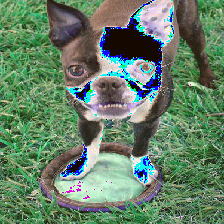

In [20]:
xx = Xv[1,:,:,:]
xx1=xx+127
xximg=PIL.Image.fromarray(xx1.astype('uint8'),'RGB')
xximg

In [21]:
y = model.predict(np.expand_dims(xx, axis=0))

In [22]:
yv[1,:]

array(['010d65bd29d246aea53d9849da142ccf', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [23]:
i=1
filename = sample_submission['id'][i]
img = read_img(filename, 'test', (INPUT_SIZE, INPUT_SIZE))
x = preprocess_input(np.expand_dims(img.copy(), axis=0))
y = model.predict(x)

In [24]:
print(y)

[[5.74969976e-13 6.96208230e-11 3.63820502e-10 3.15518943e-12
  7.17312254e-09 4.68154866e-13 1.37121011e-12 8.56448801e-11
  9.27536368e-13 2.46146614e-09 3.16495025e-05 6.13991913e-10
  7.90730816e-13 5.29814005e-11 2.08887900e-06 1.36446789e-13
  5.39544867e-11 8.89093599e-07 1.65878465e-12 5.13113369e-13
  1.80505236e-17 8.17054979e-10 1.62515730e-11 9.86010810e-15
  9.34141900e-15 2.32064012e-09 2.57204202e-10 8.03107298e-07
  2.97911110e-14 1.48867616e-06 3.00449244e-07 1.95500993e-09
  7.82726121e-15 9.47488073e-13 1.10979455e-11 1.65195457e-09
  8.96666747e-13 5.53477446e-12 1.61259547e-12 5.18142336e-15
  3.09777186e-15 6.09047058e-12 4.55656712e-09 1.22585446e-02
  8.02433897e-10 1.24705229e-11 4.38889813e-10 9.32417773e-17
  6.24148696e-14 1.10859469e-06 2.19124268e-15 4.71448401e-11
  2.47823955e-05 1.71670772e-15 1.00444812e-10 1.37376438e-13
  3.02940927e-14 2.04712657e-12 3.27953463e-11 2.51785008e-12
  3.07414025e-11 1.05283085e-07 1.89408661e-06 2.34081039e-08
  1.8322

In [27]:
INPUT_SIZE = 224
for i, img_id in tqdm(enumerate(sample_submission['id'])):
    img = read_img(img_id, 'test', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    y = model.predict(x)
    sample_submission.iloc[i,1:121] = np.asarray(y[0,0:120])

10357it [13:33, 12.73it/s]


In [ ]:
#sample_submission.iloc[1,1:121] = np.asarray(y[0,0:120])

In [ ]:
#sample_submission.head()

In [28]:
sample_submission.to_csv('submission3.csv',index=False)